# Learning Rough Bergomi Model

Owen Futter

## Load in Packages & Data Admin

In [3]:
%%capture
!git clone "https://github.com/ryanmccrickerd/rough_bergomi.git"
!pip install iisignature
!pip install tslearn
!pip install git+https://github.com/crispitagorico/sigkernel.git
!pip install torchcde

In [4]:
%%capture
import numpy as np
import matplotlib
from matplotlib import rc
import matplotlib.pyplot as plt
%matplotlib inline

rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
!apt install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng

import pandas as pd
import pickle
import seaborn as sns
import torch
import torch.cuda
from rbergomi import rBergomi
from utils import bsinv
vec_bsinv = np.vectorize(bsinv)
import sigkernel
from tqdm.notebook import tqdm
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
device = torch.device("cuda:0")
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit
from sklearn.ensemble import RandomForestRegressor
import iisignature
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

import math
import torch
import torchcde

% matplotlib inline

## 1a. Sampling Brownian Paths

Perhaps the most classical way to sample the Brownian paths is via the Euler-Maruyama method and Cholesky decomposition. These 2 correlated Brownian Motions will be the driving noise for our spot and variance sample paths. 

For this discretisation scheme we create a partition of $[0,T]$ with time intervals of equal length $\Delta t$, then the increment of our Brownian Motions over such a time interval is $dW_{t}^i = W_{t+\Delta t}^i - W_t^i \sim \mathcal{N}(0,\Delta t)$, for $i=1,2, t \in [0,T]$

So therefore in 2 dimensions, we have:

$$
\begin{pmatrix} 
dW_t^1 \\
dW_t^2
\end{pmatrix}
\sim
\mathcal{N} (0, \Sigma)
$$

where we have that $\Sigma$ is:
$$
\Sigma =
\begin{pmatrix} 
\Delta t & \rho \Delta t\\
\rho \Delta t & \Delta t
\end{pmatrix}
$$

We can use the Cholesky Decomposition to find a lower triangular matrix $A$ such that $\Sigma = AA^T$. Then $AZ \sim \mathcal{N}(0,\Sigma)$ where $Z \sim \mathcal{N}(0,1)$ is a standard normal.

Solving for $A$ we obtain:

$$
A = 
\begin{pmatrix} 
\sqrt{\Delta t} & 0 \\
\rho \sqrt{\Delta t} & \sqrt{\Delta t} \sqrt{1-\rho^2}
\end{pmatrix}
$$

Therefore, we have that:

\begin{align}
dW_1 & = \sqrt{\Delta t} Z_1 \\
dW_2 & = \rho \sqrt{\Delta t} Z_1 + \sqrt{\Delta t} \sqrt{1-\rho^2} Z_2
\end{align}

and hence we can explicitly calculate the Brownian Motion vectors in terms of standard normal distributions $Z_1, Z_2$.

However, it must be said that this method above via Cholesky decomposition is very inefficient when simulating a large number of paths and so can be improved by the efficient hybrid BSS scheme introduced by Bennedsen, Lunde and Pakkanen. 

## 1b. Considering the rBergomi Model

We consider the rBergomi model below which is a non-Markovian generalisation of the Bergomi model. Rough stochastic vol models are especially accurate since they capture some of the well-known stylised facts of real financial time series such as serial correlation and similar tail behaviours. The setup is as follows:

$$
S_t = \exp \left( \int^t_0 \sqrt{V_t} dB_u - \frac{1}{2} \int^t_0 V_u du \right) 
$$

$$
B_u = \rho W_u^1 + \sqrt{1-\rho^2} W_u^2
$$

$$
V_t = \xi \exp \left( \eta Y_t^a - \frac{\eta^2}{2} t^{2a-1} \right)
$$

$$
Y_t^a = \sqrt{2a+1} \int^t_0 (t-u)^a dW_u^1
$$

In the model above, we must simulate correlated brownian paths $W_u^1, W_u^2$ using the methods described above, as well as simulating from the Volterra process $Y_t^a$ which is the driving process of our variance sample paths. We can do so using the efficient hybrid scheme mentioned above.

Intuitively we can look at the parameters within the model:

- $\rho$ : This is the anticorrelation between the Brownian motion that drives the volatility process with the Brownian motion driving the price process
- $a$ : This is the roughness index parameter. Our variance process will therfore then be ($2a+1$-Holder continuous)
- $\xi$ : Is our 'long term' variance parameter - which when non-constant can be expressed as $\xi(u)$, namely the forward variance curve for all future tenors.
- The product $\rho \eta$ sets the level of the ATM skew for longer
expirations

In practice we are able to calibrate these parameters to market data via deep learning methods for example. In this assignment we will use known fixed parameters.

## 2. Constructing Price Trajectories

We will now use the above details to simulate price trajectories using the rBergomi framework.

We will sample $N=1000$ sample price paths, each with $n=50$ timesteps. We will take parameters as:
- Roughness Index: $a=-0.43$
- Anticorrelation: $\rho=-0.9$
- Constant Forward Variance: $\xi = 0.235^2$
- $\eta = 1.9$

In these simulations we use the rBergomi package. We can create an instance of the rBergomi class for our given parameters:

In [5]:
rB = rBergomi(n = 50, N = 1000, T = 1.0, a = -0.43)

In [6]:
np.random.seed(10)

First, generate the correlated Brownian increments using methods described above.


In [7]:
dW1 = rB.dW1()
dW2 = rB.dW2()

This allows us to generate the Brownian motion $B_u$:

$$
B_u = \rho W_u^1 + \sqrt{1-\rho^2} W_u^2
$$

In [8]:
dB = rB.dB(dW1, dW2, rho = -0.9)

We can then also generate our Volterra process using the Brownian increments:

$$
Y_t^a = \sqrt{2a+1} \int^t_0 (t-u)^a dW_u^1
$$


In [9]:
Y = rB.Y(dW1)

This then allows us to construct the variance process $V_t$:

$$
V_t = \xi \exp \left( \eta Y_t^a - \frac{\eta^2}{2} t^{2a-1} \right)
$$



In [10]:
V = rB.V(Y, xi = 0.235**2, eta = 1.9) 

Finally, we can create our spot process which is a function of all 3 of the above computed processes:

$$
S_t = \exp \left( \int^t_0 \sqrt{V_t} dB_u - \frac{1}{2} \int^t_0 V_u du \right) 
$$

In [11]:
S = rB.S(V, dB)

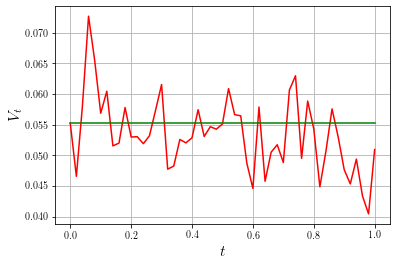

In [12]:
# We can take a look at how our Variance process behaves over time, with average
# variance of 0.235^2

plot, axes = plt.subplots()
axes.plot(rB.t[0,:], np.mean(V, axis = 0), 'r')
axes.plot(rB.t[0,:], 0.235**2 * np.ones_like(rB.t)[0,:], 'g')
axes.set_xlabel(r'$t$', fontsize=16)
axes.set_ylabel(r'$V_t$', fontsize=16)
plt.grid(True)

We now need to split our data into the input-output pairs $\{(W_{i,[0,T]}, S_{i,T}) \}^N_{i=1}$. We first construct $W_{i,[0,t]}$ from $dW$, and then we perform a train test split.

In [20]:
# Creating W_1 and W_2 then stacking. To create S_T we take the final value for each price trajectory
W = np.stack([dW1[:,:,0].cumsum(axis=1), dW2.cumsum(axis=1)], axis=1)
W = W.reshape(W.shape[0], W.shape[2], W.shape[1])
S_T = S[:,-1]

In [21]:
# Create the train-test-eval split 
W_train, W_test_temp, S_T_train, S_T_test_temp = train_test_split(W, S_T, test_size=0.30, random_state=42)
W_test, W_eval, S_T_test, S_T_eval = train_test_split(W_test_temp, S_T_test_temp, test_size=0.50, random_state=41)

# Full train test set
W_tt = np.concatenate((W_train, W_test))
S_T_tt = np.concatenate((S_T_train, S_T_test))

## 3. Implementing the pipeline

### Path Transformations as SKLearn Estimators

In order to include the path transformations in an SKLearn pipeline, we must first transform them into SKLearn estimators. The implementations for AddTime() and LeadLag() are identical to those seen in class, and the implementation for the signature is similar with the only hyperparamter the truncation level (as default set to $2$).

In [25]:
# Code for adding time and LeadLag transformations. From notebook shared in class
class AddTime(BaseEstimator, TransformerMixin):
    def __init__(self, init_time=0., total_time=1.):
        self.init_time = init_time
        self.total_time = total_time

    def fit(self, X, y=None):
        return self

    def transform_instance(self, X):
        t = np.linspace(self.init_time, self.init_time + 1, len(X))
        return np.c_[t, X]

    def transform(self, X, y=None):
        return [self.transform_instance(x) for x in X]


class LeadLag(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform_instance(self, X):
        lag = []
        lead = []

        for val_lag, val_lead in zip(X[:-1], X[1:]):
            lag.append(val_lag)
            lead.append(val_lag)

            lag.append(val_lag)
            lead.append(val_lead)

        lag.append(X[-1])
        lead.append(X[-1])

        return np.c_[lag, lead]

    def transform(self, X, y=None):
        return [self.transform_instance(x) for x in X]

# Add signature as an sklearn estimator
class ApplySignatureTransform(BaseEstimator, TransformerMixin):
    def __init__(self, level = 2):
        self.level = level
        pass

    def fit(self, X, y=None):
        return self

    def transform_instance(self, X):
        signature = iisignature.sig(X, self.level)

        return signature

    def transform(self, X, y=None):
        return [self.transform_instance(x) for x in X]

# Kernel Learning

## RBF Signature Kernel
Let $\mathcal{X}=\mathbb{R}^d$, and let $k_{RBF}$ be the symmetric, positive definite kernel defined by

\begin{equation*}
k_{RBF}(x,y) = \exp\left(-\frac{\|x-y\|^2}{\sigma^2}\right),
\end{equation*}

where $\sigma>0$ is a hyperparameter; small $\sigma$ decreases the "distance". Let $\mathcal{H}_{k_{RBF}}$ be the associated RKHS.

Let $X, Y:[0,1]\to\mathbb{R}^d$ continous paths of bounded variation, then assuming appropriate regularity of $k_{RBF}(X,\cdot):t\mapsto k_{RBF}(X,\cdot)\in\mathcal{H}_{k_{RBF}}$ and $k_{RBF}(Y,\cdot):t\mapsto k_{RBF}(Y,\cdot)\in\mathcal{H}_{k_{RBF}}$, we may assume that their signatures are well defined and live in the Hilbert space $\overline{T(\mathcal{H}_{k_{RBF}})}$. Under these assumptions we may construct the following "non-Euclidean" kernel on continuoud $\mathbb{R}^d$ valued paths of bounded variation, defined by

\begin{equation*}
K(X,Y)=\left\langle S(k_{RBF})(X,\cdot)),  S(k_{RBF})(Y,\cdot))\right\rangle_{T((\mathcal{H}_{k_{RBF}}))}.
\end{equation*}

Defining $U(s,t)=K\left(\left.X\right|_{[0,s]}, \left.Y\right|_{[0,t]}\right)$, then it can be shown (as seen in the lecture notes) that $U(s,t)$ satisfies the PDE
\begin{align*}
\frac{\partial^2 U}{\partial u\partial t} &= \left\langle \frac{d}{ds}k_{RBF}(X,\cdot),  \frac{d}{dt}k_{RBF}(Y,\cdot)\right\rangle_{\mathcal{H}_{k_{RBF}}}\\
&= \frac{\partial^2 }{\partial u\partial t} \left\langle k_{RBF}(X,\cdot),  k_{RBF}(Y,\cdot)\right\rangle_{\mathcal{H}_{k_{RBF}}}\\
&= \frac{\partial^2 }{\partial u\partial t} k_{RBF}(X_s,Y_t)
\end{align*}

where the second equality follows from the linearity of differentiation and the inner product and the last equality from RKHS property. The last line is efficiently implemented in the sigkernel package we have obtained from https://github.com/crispitagorico/sigkernel.git.

## Kernel Ridge

Kernel Ridge regression is a regularised minimsation problem where the Hypothesis space is the RKHS. With train data $\{(x_i,y_i)\}_{i=1}^n$, this may be written as

\begin{equation*}
\hat{f} = \text{argmin}_{f\in\mathcal{H}_k}\frac{1}{n}\sum_{i=1}^n L(y_i, f(x_i))+\lambda \|f\|_{\mathcal{H}_k}^2.
\end{equation*}

Here $L$ is a loss function which we take to be squared error and $\lambda$ is the regularisation parameter. As mentioned in the lecture notes, as $\|f\|_{\mathcal{H}_k}$ decreases, $f$ gets smoother and so regularisation is required to prevent overfitting. Since we take squared loss the solution $\hat{f}$ may be written explicitly as

\begin{equation*}
\hat{f}(x) = \sum_{i=1}^n\alpha_ik(x,x_i),
\end{equation*}
where 
\begin{equation*}
(\alpha_1,\dots,\alpha_n)^\top = (G+n\lambda I_n)^{-1}(y_1,\dots,y_n)^\top,
\end{equation*}
where $G$ is the gram matrix $G_{ij} = k(x_i,x_j)$.

Note that $\hat{f}$ is linear in kernel space and since our kernel is highly non-linear (signature combined with RBF) the resultant function is non-linear in the input space.


### Computing the Gram matrices

Due to an issue with the way sigkernel.compute_gram assigns memory we ran into computational issues and exceeded colab RAM limits.

In order to fix this, we calculated the gram matrix in batches (of size 25 in our case) and then stacked the resulting blocks in order to avoid assigning more memory than available on the GPU.

In [24]:
# compute gram matrix in batches

def batch_gram(tensor_1, tensor_2, sigma = 1, batchsize = 25):
    # Initialise output as empty Gram matrix
    Gram = np.empty((tensor_1.shape[0], tensor_2.shape[0]))

    # Load data into Dataloader for easy batch extraction
    dataloader_1 = torch.utils.data.DataLoader(tensor_1, batch_size=batchsize)
    dataloader_2 = torch.utils.data.DataLoader(tensor_2, batch_size=batchsize)

    # Initialise sigkernel
    static_kernel = sigkernel.RBFKernel(sigma = sigma)
    signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order=0)

    # Compute gram matrix in batches and stack in Gram accordingly
    i_1 = 0
    for batch_1 in dataloader_1:
        i_2 = 0
        for batch_2 in dataloader_2:
            s_1 = batch_1.shape[0]
            s_2 = batch_2.shape[0]
            Gram[i_1:i_1 + s_1, i_2:i_2 + s_2] = signature_kernel.compute_Gram(batch_1, batch_2, sym = False).cpu().numpy()
            i_2 += s_2
        i_1 += s_1
    return Gram

### Tuning Hyperparameters

Looking for the optimal kernel ridge model we consider the following pipeline



1.   Optionally normalise data
2.   Optionally apply LeadLag
3.   Optionally apply AddTime
4.   Perform kernel ridge regression with parameters $\sigma$ in RBF kernel and regularisation parameter $\alpha$ in the regression

We optimise over the pipeline and the hyperparameters $\alpha$ and $\sigma$.



We manually created the pipeline; partially to avoid the issue of implementing SigKernel as an estimator in SKLearn and ensuring the test-train Gram matrix is computed correctly. Additionally whilst testing the issue of memory assignment, a for loop made investigating this issue easier. The ranges taken for the hyperparameters were chosen via initial testing and a sparser gridsearch. In particular, for smaller values of $\alpha$ the Gram matrices (despite the regularisation) were too ill-conditioned.

In [ ]:
results = []
batchsize = 25
for normalise in tqdm([False, True]):
    train = W_train
    test = W_test
    # Optionally Normalise
    if normalise:
        train_n = TimeSeriesScalerMeanVariance().fit_transform(train)
        test_n = TimeSeriesScalerMeanVariance().fit_transform(test)
    else:
        train_n = train
        test_n = test

    # Optionally LeadLag
    for lead_lag in tqdm([False, True]):
        if lead_lag:
            train_ll = LeadLag().transform(train_n)
            test_ll = LeadLag().transform(test_n)
        else:
            train_ll = train_n
            test_ll = test_n

        # Optionally AddTime
        for add_time in tqdm([False, True]):
            if add_time:
                train_at = AddTime().transform(train_ll)
                test_at = AddTime().transform(test_ll)
            else:
                train_at = train_ll
                test_at = test_ll
            
            # Compute Gram matrices
            for sigma in tqdm([0.25, 0.3, 0.35, 0.45, 0.5, 0.6, 7.5e-1, 1., 1.25]):
                torch.cuda.empty_cache()
                # Converrt to tensor
                tensor_train = torch.tensor(train_at, dtype=torch.float64, device = device)
                tensor_test = torch.tensor(test_at, dtype=torch.float64, device = device)

                # Compute Required Gram matrices
                train_train_gram = batch_gram(tensor_train, tensor_train)
                test_train_gram = batch_gram(tensor_test, tensor_train)
                # Perform kernel ridge
                for alpha in tqdm(np.logspace(1/2, 3/2, num = 12)):
                    torch.cuda.empty_cache()
                    # Fit Model
                    krr = KernelRidge(kernel = "precomputed", alpha = alpha)
                    krr.fit(train_train_gram, S_T_train)

                    # Predict and calculate error
                    predictions = krr.predict(test_train_gram)
                    error = mean_squared_error(S_T_test, predictions)

                    # Append results to list
                    results.append([normalise, lead_lag, add_time, sigma, alpha, error])

# Turn Results into DataFrame
kernel_results_df = pd.DataFrame(data = results, columns = ["Normalise", "LL", "AT", "Sigma", "Alpha", "MSE"])




In [ ]:
# Sort results by MSE and print top 15 models
kernel_results_df = kernel_results_df.sort_values(by=["MSE"])
kernel_results_df.head(100)

,Normalise,LL,AT,Sigma,Alpha,MSE
135,False,False,True,0.35,5.925531,0.016693
183,False,False,True,0.75,5.925531,0.016693
111,False,False,True,0.25,5.925531,0.016693
195,False,False,True,1.00,5.925531,0.016693
171,False,False,True,0.60,5.925531,0.016693
...,...,...,...,...,...,...
127,False,False,True,0.30,13.688745,0.017285
199,False,False,True,1.00,13.688745,0.017285
139,False,False,True,0.35,13.688745,0.017285
175,False,False,True,0.60,13.688745,0.017285


## 4. Testing the optimal configuration on the validation set

From the above, the optimal pipeline is:



1.   Don't normalise
2.   Don't apply lead lag
3.   Do add time
4.   $\sigma = 0.35$ in the RBF signature kernel
5.   $\alpha=5.925531$ as the regularisation parameter in the kernel ridge regression 

We now fit the optimal model to the train-test set and evaluate on the validation set.

In [ ]:
# Apply pipeline and fit model to full train test set
tt_at = AddTime().transform(W_tt)
eval_at = AddTime().transform(W_eval)
# Convert to tensor
tensor_tt = torch.tensor(tt_at, dtype = torch.float64, device = device)
tensor_eval = torch.tensor(eval_at, dtype = torch.float64, device = device)

# Compute Required Gram matrices
static_kernel = sigkernel.RBFKernel(sigma = 0.35)
tt_tt_gram = batch_gram(tensor_tt, tensor_tt)
tt_eval_gram = batch_gram(tensor_eval, tensor_tt)

# Fit model to tt_tt_gram
krr = KernelRidge(kernel = "precomputed", alpha = 5.925531)
krr.fit(tt_tt_gram, S_T_tt)
pickle.dump(krr, open("/content/gdrive/My Drive/RPML_CW2/sig_kernel_krr.sav", 'wb'))
# krr = pickle.load(open("/content/gdrive/My Drive/RPML_CW2/sig_kernel_krr.sav", 'rb'))

# Predict and calculate error
eval_predictions = krr.predict(tt_eval_gram)
mse = mean_squared_error(S_T_eval, eval_predictions)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  """


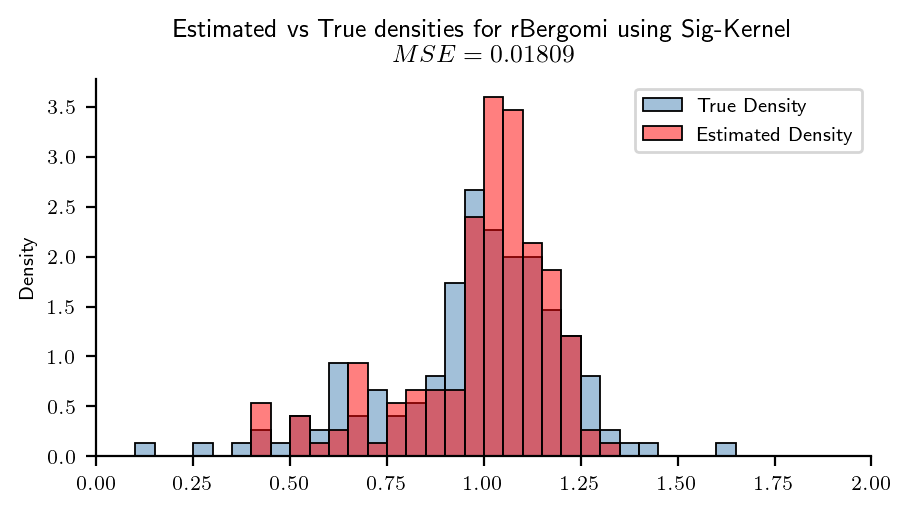

In [ ]:
# Plot the histograms of the "true" terminal spot price S_T vs the estimated values (on the validation set).
# Initialise figure
binsize = np.arange(0,2,0.05)
plt.rcParams['figure.dpi'] = 200
fig, ax1 = plt.subplots(1,1, figsize=(5,2.5))
# Produce a scatter plot with true values on x-axis and predictions on y-axis
sns.histplot(S_T_eval, bins=binsize, alpha = 0.5, color="steelblue", stat="density", label = "True Density",common_bins=True)
sns.histplot(eval_predictions, bins=binsize, alpha = 0.5, color="red", stat="density", label = "Estimated Density",common_bins=True)
ax1.set_title('Estimated vs True densities for rBergomi using Sig-Kernel \n'+ "$MSE = {:.5f}$".format(mse), fontsize=9)
# Set plot parameters
ax1.tick_params(axis='y', labelsize=7)
ax1.yaxis.label.set_size(7)
ax1.xaxis.label.set_size(7)
right_side = ax1.spines["right"]
right_side.set_visible(False)
top_side = ax1.spines["top"]
top_side.set_visible(False)
plt.xlim([0,2])
plt.legend(loc = "upper right", fontsize = 7)
ax1.tick_params(axis='x', labelsize=7)
ax1.tick_params(axis='y', labelsize=7)
plt.show()

To better visualise the performance we plot the true values against predicted values.

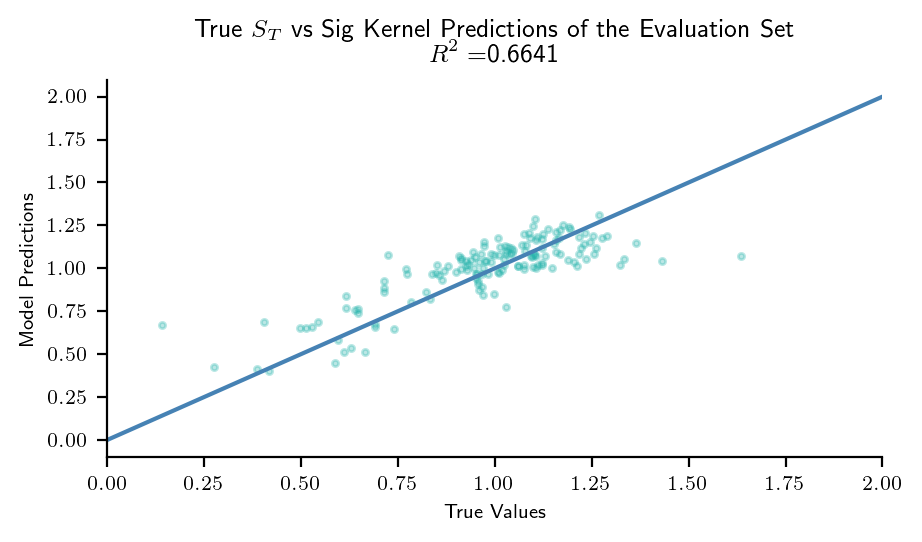

In [ ]:
# We now plot The predicted values against the true values and report the R^2 score
# Initialise figure
plt.rcParams['figure.dpi'] = 200
fig, ax1 = plt.subplots(1,1, figsize=(5,2.5))
# Produce a scatter plot with true values on x-axis and predictions on y-axis
plt.scatter(S_T_eval, eval_predictions, s = 5, alpha = 0.3, color = 'lightseagreen')
ax1.set_title('True $S_T$ vs Sig Kernel Predictions of the Evaluation Set \n' + "$R^2 = $" + "{:.4f}".format(r2_score(S_T_eval, eval_predictions)), fontsize=9)
# Set plot parameters
plt.plot([0,2], [0,2], color = 'steelblue', linewidth=1.5)
ax1.tick_params(axis='y', labelsize=7)
ax1.yaxis.label.set_size(7)
ax1.xaxis.label.set_size(7)
right_side = ax1.spines["right"]
right_side.set_visible(False)
top_side = ax1.spines["top"]
top_side.set_visible(False)
plt.xlim([0,2])
plt.ylabel("Model Predictions")
plt.xlabel("True Values")
ax1.tick_params(axis='x', labelsize=7)
ax1.tick_params(axis='y', labelsize=7)
plt.show()

The above plots shows the out of sample performance for the Signature Kernel Ridge Regression. The first plot shows the density comparison where we can see that is certainly not a bad density estimation overall and we have a low MSE of 0.01809. However, the model does have its shortcomings as the bulk is very densely fitted and we lose some predictive power in the tails, this is shown well in the second plot above which displays the difficulty in predicting the right tail especially. Heuristically, however it appears that the distribution of the residuals is relatively symmetric at both ends hinting that the model has not been too overfit to the training data.

We now repeat the above two plots with the train set to assess model over/under-fitting.

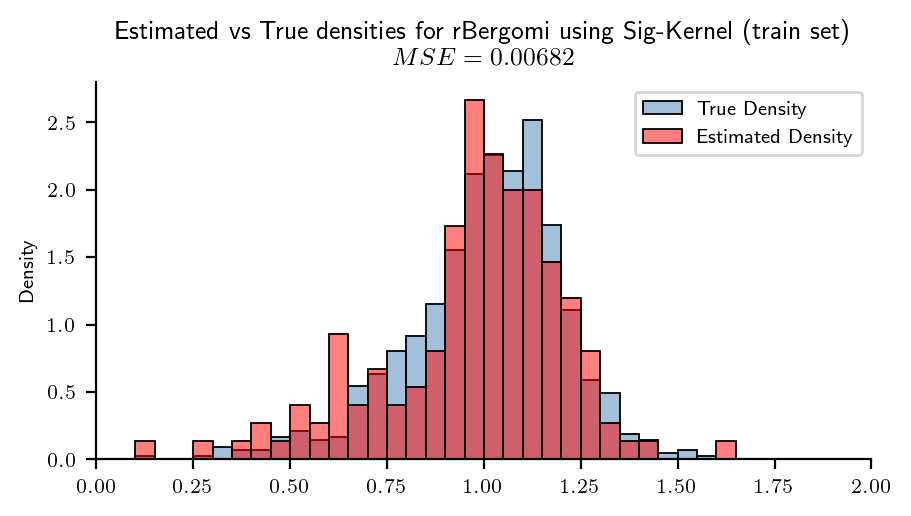

In [ ]:
tt_predictions = krr.predict(tt_tt_gram)
mse = mean_squared_error(S_T_tt, tt_predictions)
# Plot histograms of the "true" S_T vs predicted S_t on the evaluation set
binsize = np.arange(0,2,0.05)
plt.rcParams['figure.dpi'] = 200
fig, ax1 = plt.subplots(1,1, figsize=(5,2.5))
# Produce a scatter plot with true values on x-axis and predictions on y-axis
sns.histplot(S_T_tt, bins=binsize, alpha = 0.5, color="steelblue", stat="density", label = "True Density",common_bins=True)
sns.histplot(S_T_eval, bins=binsize, alpha = 0.5, color="red", stat="density", label = "Estimated Density",common_bins=True)
ax1.set_title('Estimated vs True densities for rBergomi using Sig-Kernel (train set) \n'+ "$MSE = {:.5f}$".format(mse), fontsize=9)
# Set plot parameters
ax1.tick_params(axis='y', labelsize=7)
ax1.yaxis.label.set_size(7)
ax1.xaxis.label.set_size(7)
right_side = ax1.spines["right"]
right_side.set_visible(False)
top_side = ax1.spines["top"]
top_side.set_visible(False)
plt.xlim([0,2])
plt.legend(loc = "upper right", fontsize = 7)
ax1.tick_params(axis='x', labelsize=7)
ax1.tick_params(axis='y', labelsize=7)
plt.show()

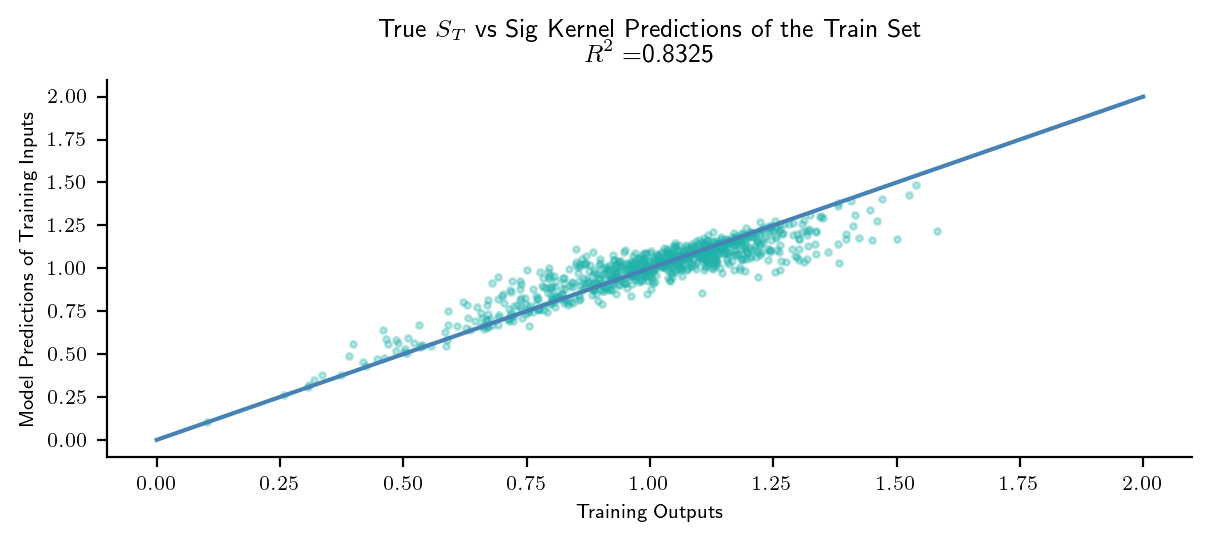

In [ ]:
# Initialise figure
plt.rcParams['figure.dpi'] = 200
fig, ax1 = plt.subplots(1,1, figsize=(7,2.5))
# Produce a scatter plot with true values on x-axis and predictions on y-axis
plt.scatter(S_T_tt, tt_predictions, s = 5, alpha = 0.3, color = 'lightseagreen')
ax1.set_title('True $S_T$ vs Sig Kernel Predictions of the Train Set \n' + "$R^2 = $" + "{:.4f}".format(r2_score(S_T_tt, tt_predictions)), fontsize=9)
# Set plot parameters
plt.plot([0,2], [0,2], color = 'steelblue', linewidth=1.5)
ax1.tick_params(axis='y', labelsize=7)
ax1.yaxis.label.set_size(7)
ax1.xaxis.label.set_size(7)
right_side = ax1.spines["right"]
right_side.set_visible(False)
top_side = ax1.spines["top"]
top_side.set_visible(False)
plt.ylabel("Model Predictions of Training Inputs")
plt.xlabel("Training Outputs")
ax1.tick_params(axis='x', labelsize=7)
ax1.tick_params(axis='y', labelsize=7)
plt.show()

Again, we can monitor how exactly the Sig-KRR fit during the training phase, which did fit rather well, especially given we only have a relatively small sample size. We have an $R^2\approx 0.83$ on the train set, but visually we seem to have underfit the low end (overestimated the true values) of the distribution and underfit the upper end as well (underestimating the true values). 

## 5. Training a Neural Controlled Differential Equation (NCDE):

We can deploy a NCDE to learn the same mapping from the Brownian noise input to the rBergomi terminal spot price through the form of a time varying dynamical system. We can view the NCDE as the continuous-time limit of recurrent neural networks. 

Just like the RNN, there exists an evolving hidden state $Z$ which is fed into a linear map $\pi_{\theta}$ to produce an output, which in our case will be the terminal spot price of the simulated rBergomi price path. We can then feed this output into the loss function and train via SGD with MSE loss function.

We use the torchcde library which supports both backpropagation through the solver and the adjoint method.

### First, train a NCDE on the original Brownian noise time series with time as an additional channel

Suppose we have a stream of data $X$ that evolves through time via some latent variable $Z$, we can set this system up as follows:

Let $\ell_{\theta} : \mathbb{R}^n \to \mathbb{R}^h$ and $f_\theta : \mathbb{R}^{h+1} \to \mathbb{R}^{h \times m}$ be two feedforward neural networks. Let $\pi_\theta : \mathbb{R}^h \to \mathbb{R}^n$ be a linear map, the NCDE driven by a path $X$ is of the form:

$$
Z_{t_0} = \ell_\theta(y_{t_0}), \\
Z_t = Z_{t_0} + \int^t_{t_0} f_{\theta} (t, Z_s) dX_s, \\
Y_t = \pi_{\theta} (Z_t), \text{ for } t \in (t_0, t_n] \\
$$

In [ ]:
class CDEFunc(torch.nn.Module):
    # First create CDE function that is able to do the forward pass of the solver
    def __init__(self, input_channels, hidden_channels):
        super(CDEFunc, self).__init__()
        self.input_channels = input_channels
        self.hidden_channels = hidden_channels
        # define network architecture
        self.linear1 = torch.nn.Linear(hidden_channels, 256)
        self.linear2 = torch.nn.Linear(256, input_channels * hidden_channels)
        self.device = torch.device("cuda:0") # ensure we're running on the GPU
        self.to(self.device)

    def forward(self, t, z):
        # z has shape (batch, hidden_channels)
        z = self.linear1(z)
        z = z.relu()
        z = self.linear2(z) # create flow of the network
        z = z.tanh() # non-linearity applied
        z = z.view(z.size(0), self.hidden_channels, self.input_channels)
        return z

class NeuralCDE(torch.nn.Module):
    # class that is able to package all pieces together in order to perform the integration step
    def __init__(self, input_channels, hidden_channels, output_channels, interpolation="cubic"):
        super(NeuralCDE, self).__init__()

        self.func = CDEFunc(input_channels, hidden_channels)
        self.initial = torch.nn.Linear(input_channels, hidden_channels)
        self.readout = torch.nn.Linear(hidden_channels, output_channels)
        self.interpolation = interpolation

        self.device = torch.device("cuda:0") # ensure we're running on the GPU
        self.to(self.device)

    def forward(self, coeffs):
        if self.interpolation == 'cubic':
            X = torchcde.CubicSpline(coeffs)
        elif self.interpolation == 'linear':
            X = torchcde.LinearInterpolation(coeffs)
        else:
            raise ValueError("Only 'linear' and 'cubic' interpolation methods are implemented.")

        X0 = X.evaluate(X.interval[0])
        z0 = self.initial(X0)
        

        # Then solve the ODE
        z_T = torchcde.cdeint(X=X,
                              z0=z0,
                              func=self.func,
                              t=X.interval)

        z_T = z_T[:, 1]
        pred_y = self.readout(z_T)
        return pred_y

We train an NCDE with the original Brownian Noise with time as an additional channel as a 3-dimensional path. We train the NCDE for 30 epochs with 128 hidden channels and just one hidden layer in the network, consisting of 256 neurons.

In [ ]:
def main1(num_epochs=30):
    # our function that is able to take in our designated input and architecture design
    W_train_tensor = torch.tensor(W_train, dtype=torch.float64, device = device)
    t = torch.linspace(0, 1, 50)
    t_ = torch.tensor(t.unsqueeze(0).unsqueeze(-1).expand(W_train_tensor.shape[0], W_train_tensor.shape[1], 1), dtype=torch.float64, device = device)
    x_ = W_train_tensor.float()
    x = torch.cat([t_, x_], dim=2)  # include time as a channel
    train_X, train_y = x.float(), torch.tensor(S_T_train, dtype=torch.float64, device = device).float() # create our train tensors

    model = NeuralCDE(input_channels=3, hidden_channels=128, output_channels=1) # input_channels=3 because we have a 2-dimensional Brownian noise input and a time channel
    optimizer = torch.optim.Adam(model.parameters())

    # Now we turn our dataset into a continuous path. We do this here via Hermite cubic spline interpolation.
    train_coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(train_X)
    train_dataset = torch.utils.data.TensorDataset(train_coeffs, train_y)
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=100)
    for epoch in range(num_epochs):
        for batch in train_dataloader:
            batch_coeffs, batch_y = batch
            pred_y = model(batch_coeffs).squeeze(-1)
            loss = torch.nn.functional.mse_loss(pred_y, batch_y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        print('Epoch: {}   Training loss: {}'.format(epoch, loss.item()))

    # Now output some nice plots from our model:

    t_eval = torch.tensor(t.unsqueeze(0).unsqueeze(-1).expand(W_eval.shape[0], W_eval.shape[1], 1), dtype=torch.float64, device = device)
    x_eval = torch.tensor(W_eval, dtype=torch.float64, device = device).float()
    x_eval = torch.cat([t_eval, x_eval], dim=2)  # include time as a channel
    test_X, test_y = x_eval.float(), torch.tensor(S_T_eval, dtype=torch.float64, device = device).float()
    test_coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(test_X)
    pred_y = model(test_coeffs).squeeze(-1)
    eval_predictions = pred_y.detach().cpu().numpy()
    mse = mean_squared_error(S_T_eval, eval_predictions)
    print('Mean Squared Error on Validation Set: {}'.format(mse))
    # Plot histograms of the "true" S_T vs predicted S_t on the evaluation set
    binsize = np.arange(0,2,0.05)
    plt.rcParams['figure.dpi'] = 200
    fig, ax1 = plt.subplots(1,1, figsize=(5,2.5))
    # Produce a scatter plot with true values on x-axis and predictions on y-axis
    sns.histplot(S_T_eval, bins=binsize, alpha = 0.5, color="steelblue", stat="density", label = "True Density",common_bins=True)
    sns.histplot(eval_predictions, bins=binsize, alpha = 0.5, color="red", stat="density", label = "Estimated Density",common_bins=True)
    ax1.set_title('Estimated vs True densities for rBergomi using Original NCDE \n'+ "$MSE = {:.5f}$".format(mse), fontsize=9)
    # Set plot parameters
    ax1.tick_params(axis='y', labelsize=7)
    ax1.yaxis.label.set_size(7)
    ax1.xaxis.label.set_size(7)
    right_side = ax1.spines["right"]
    right_side.set_visible(False)
    top_side = ax1.spines["top"]
    top_side.set_visible(False)
    plt.xlim([0,2])
    plt.legend(loc = "upper right", fontsize = 7)
    ax1.tick_params(axis='x', labelsize=7)
    ax1.tick_params(axis='y', labelsize=7)
    plt.show()

    # We now plot The predicted values against the true values and report the R^2 score
    # Initialise figure
    plt.rcParams['figure.dpi'] = 200
    fig, ax1 = plt.subplots(1,1, figsize=(5,2.5))
    # Produce a scatter plot with true values on x-axis and predictions on y-axis
    plt.scatter(S_T_eval, eval_predictions, s = 5, alpha = 0.3, color = 'lightseagreen')
    ax1.set_title('True $S_T$ vs Original NCDE Predictions of the Evaluation Set \n' + "$R^2 = $" + "{:.4f}".format(r2_score(S_T_eval, eval_predictions)), fontsize=9)
    # Set plot parameters
    plt.plot([0,2], [0,2], color = 'steelblue', linewidth=1.5)
    ax1.tick_params(axis='y', labelsize=7)
    ax1.yaxis.label.set_size(7)
    ax1.xaxis.label.set_size(7)
    right_side = ax1.spines["right"]
    right_side.set_visible(False)
    top_side = ax1.spines["top"]
    top_side.set_visible(False)
    plt.xlim([0,2])
    plt.ylabel("Model Predictions")
    plt.xlabel("True Values")
    ax1.tick_params(axis='x', labelsize=7)
    ax1.tick_params(axis='y', labelsize=7)
    plt.show()

    return pred_y, model

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


Epoch: 0   Training loss: 0.11308736354112625
Epoch: 1   Training loss: 0.0574493482708931
Epoch: 2   Training loss: 0.04062117636203766
Epoch: 3   Training loss: 0.030277686193585396
Epoch: 4   Training loss: 0.027041545137763023
Epoch: 5   Training loss: 0.022678332403302193
Epoch: 6   Training loss: 0.0230870321393013
Epoch: 7   Training loss: 0.022251227870583534
Epoch: 8   Training loss: 0.02207266353070736
Epoch: 9   Training loss: 0.020752711221575737
Epoch: 10   Training loss: 0.020393770188093185
Epoch: 11   Training loss: 0.020033610984683037
Epoch: 12   Training loss: 0.019402891397476196
Epoch: 13   Training loss: 0.018841620534658432
Epoch: 14   Training loss: 0.018335949629545212
Epoch: 15   Training loss: 0.018658442422747612
Epoch: 16   Training loss: 0.01876302808523178
Epoch: 17   Training loss: 0.018499527126550674
Epoch: 18   Training loss: 0.018235964700579643
Epoch: 19   Training loss: 0.017343176528811455
Epoch: 20   Training loss: 0.017209166660904884
Epoch: 21 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Mean Squared Error on Validation Set: 0.020786583499325825


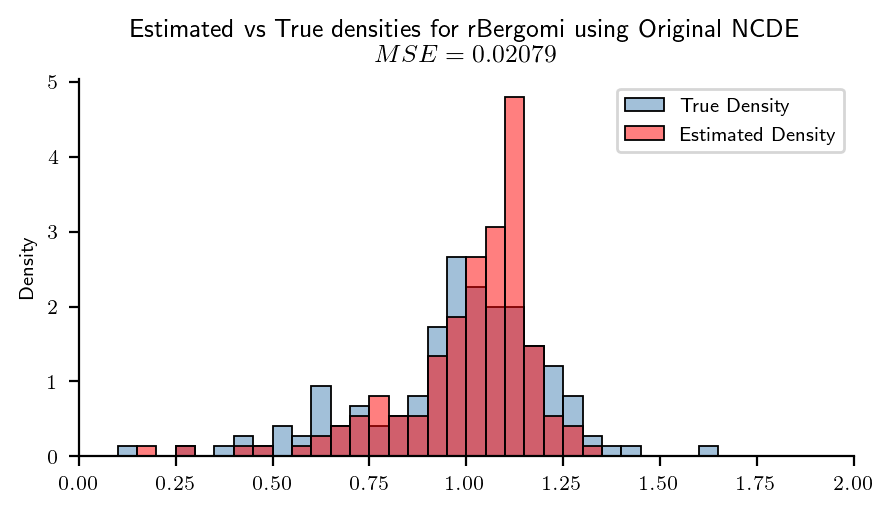

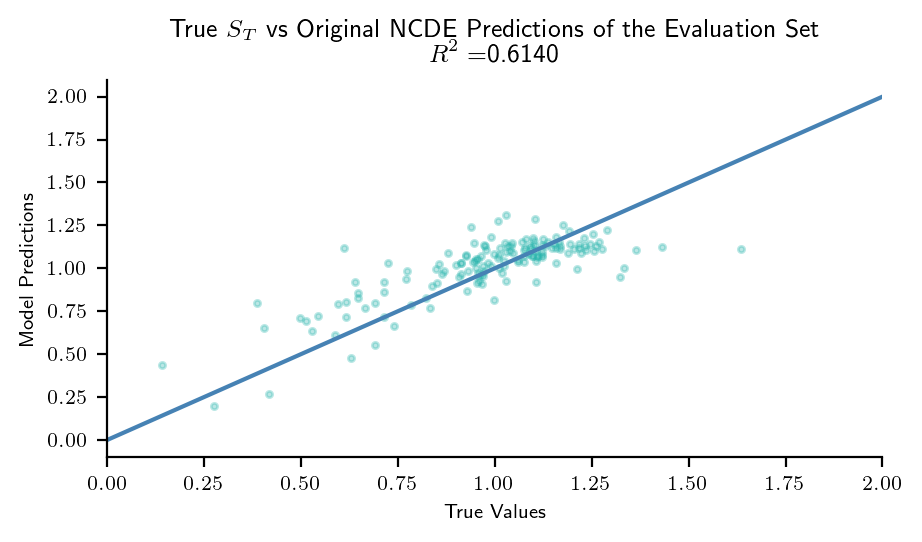

In [ ]:
if __name__ == '__main__':
    pred_y_orig, NCDE_orig_model = main1(30)

In [ ]:
pickle.dump(NCDE_orig_model, open("/content/gdrive/My Drive/RPML_CW2/NCDE_orig_model.sav", 'wb'))
# NCDE_orig_model = pickle.load(open("/content/gdrive/My Drive/RPML_CW2/NCDE_orig_model.sav", 'rb'))

## We now train an NCDE using the log signature $\log S(X)_{[0,u]}$ as the driving process instead of the time series itself:

Firstly, we need to create a log-signature process that will be the driving input for our NCDE.

This is created by taking the log signature of the path over the time interval $[0,u]$ where $u$ is eacj timestep in the path between $0$ and $1$. This is then repeated for every path in the dataset. This now gives us a 6-dimensional path of the log-signature to input into the Neural CDE.

In [ ]:
t = np.linspace(0, 1, 50)
t_ = np.tile(t,(W.shape[0],1,1)).reshape(W.shape[0], W.shape[1], 1)
W_t = np.concatenate((W, t_), axis=2)  # include time as a channel

In [ ]:
# First, we want to create the path signatures and store them appropriately for training

def create_sig_inputs(paths, sig_level):
  

    sig_shape = iisignature.logsig (paths[0,:,:],iisignature.prepare(paths[0,0:50,:].shape[1], sig_level)).shape[0]

    size = (paths.shape[0],paths.shape[1],sig_shape)
    logsigs = np.zeros(size)

    for i in tqdm(range(size[0])):

      for j in range(size[1]):

        s = iisignature.prepare(paths[i,0:j+1,:].shape[1], sig_level )
        logsignature = iisignature.logsig(paths[i,0:j+1,:], s )

        logsigs[i,j,:] = logsignature

    return logsigs

In [ ]:
# logsig_input = create_sig_inputs(W_t, sig_level=2)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
# np.save(("/content/gdrive/My Drive/RPML_CW2/logsig_input.npy"), logsig_input)

In [ ]:
logsig_input = np.load("/content/gdrive/My Drive/RPML_CW2/logsig_input.npy")

In [ ]:
W_train_LS, W_test_temp_LS, S_T_train, S_T_test_temp = train_test_split(logsig_input, S_T, test_size=0.30, random_state=42)
W_test_LS, W_eval_LS, S_T_test, S_T_eval = train_test_split(W_test_temp_LS, S_T_test_temp, test_size=0.50, random_state=41)

# Full train test set
W_tt_LS = np.concatenate((W_train_LS, W_test_LS))
S_T_tt_LS = np.concatenate((S_T_train, S_T_test))

### NCDE Model for Log-Signature Input

We again train an NCDE for 30 epochs with 128 hidden channels and just one hidden layer in the network, consisting of 256 neurons. However, this time our driving input $X$ is the log signature of the brownian noise.

In [ ]:
def main2(num_epochs=30):
    W_train_tensor = torch.tensor(W_train_LS, dtype=torch.float64, device = device)
    t = torch.linspace(0, 1, 50)
    t_ = torch.tensor(t.unsqueeze(0).unsqueeze(-1).expand(W_train_tensor.shape[0], W_train_tensor.shape[1], 1), dtype=torch.float64, device = device)
    x_ = W_train_tensor.float()
    x = torch.cat([t_, x_], dim=2)  # include time as a channel
    train_X, train_y = x.float(), torch.tensor(S_T_train, dtype=torch.float64, device = device).float()

    model = NeuralCDE(input_channels=7, hidden_channels=150, output_channels=1)
    optimizer = torch.optim.Adam(model.parameters())

    # Now we turn our dataset into a continuous path. We do this here via Hermite cubic spline interpolation.
    train_coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(train_X)
    train_dataset = torch.utils.data.TensorDataset(train_coeffs, train_y)
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=100)
    for epoch in range(num_epochs):
        for batch in train_dataloader:
            batch_coeffs, batch_y = batch
            pred_y = model(batch_coeffs).squeeze(-1)
            loss = torch.nn.functional.mse_loss(pred_y, batch_y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        print('Epoch: {}   Training loss: {}'.format(epoch, loss.item()))

    # Now output some nice plots from our model:

    t_eval = torch.tensor(t.unsqueeze(0).unsqueeze(-1).expand(W_eval_LS.shape[0], W_eval_LS.shape[1], 1), dtype=torch.float64, device = device)
    x_eval = torch.tensor(W_eval_LS, dtype=torch.float64, device = device).float()
    x_eval = torch.cat([t_eval, x_eval], dim=2)  # include time as a channel
    test_X, test_y = x_eval.float(), torch.tensor(S_T_eval, dtype=torch.float64, device = device).float()
    test_coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(test_X)
    pred_y = model(test_coeffs).squeeze(-1)
    eval_predictions = pred_y.detach().cpu().numpy()
    mse = mean_squared_error(S_T_eval, eval_predictions)
    print('Mean Squared Error on Validation Set: {}'.format(mse))

    # Plot histograms of the "true" S_T vs predicted S_t on the evaluation set
    binsize = np.arange(0,2,0.05)
    plt.rcParams['figure.dpi'] = 200
    fig, ax1 = plt.subplots(1,1, figsize=(5,2.5))
    # Produce a scatter plot with true values on x-axis and predictions on y-axis
    sns.histplot(S_T_eval, bins=binsize, alpha = 0.5, color="steelblue", stat="density", label = "True Density",common_bins=True)
    sns.histplot(eval_predictions, bins=binsize, alpha = 0.5, color="red", stat="density", label = "Estimated Density",common_bins=True)
    ax1.set_title('Estimated vs True densities for rBergomi using Log-Sig NCDE \n'+ "$MSE = {:.5f}$".format(mse), fontsize=9)
    # Set plot parameters
    ax1.tick_params(axis='y', labelsize=7)
    ax1.yaxis.label.set_size(7)
    ax1.xaxis.label.set_size(7)
    right_side = ax1.spines["right"]
    right_side.set_visible(False)
    top_side = ax1.spines["top"]
    top_side.set_visible(False)
    plt.xlim([0,2])
    plt.legend(loc = "upper right", fontsize = 7)
    ax1.tick_params(axis='x', labelsize=7)
    ax1.tick_params(axis='y', labelsize=7)
    plt.show()

    # We now plot The predicted values against the true values and report the R^2 score
    # Initialise figure
    plt.rcParams['figure.dpi'] = 200
    fig, ax1 = plt.subplots(1,1, figsize=(5,2.5))
    # Produce a scatter plot with true values on x-axis and predictions on y-axis
    plt.scatter(S_T_eval, eval_predictions, s = 5, alpha = 0.3, color = 'lightseagreen')
    ax1.set_title('True $S_T$ vs Log-Sig NCDE Predictions of the Evaluation Set \n' + "$R^2 = $" + "{:.4f}".format(r2_score(S_T_eval, eval_predictions)), fontsize=9)
    # Set plot parameters
    plt.plot([0,2], [0,2], color = 'steelblue', linewidth=1.5)
    ax1.tick_params(axis='y', labelsize=7)
    ax1.yaxis.label.set_size(7)
    ax1.xaxis.label.set_size(7)
    right_side = ax1.spines["right"]
    right_side.set_visible(False)
    top_side = ax1.spines["top"]
    top_side.set_visible(False)
    plt.xlim([0,2])
    plt.ylabel("Model Predictions")
    plt.xlabel("True Values")
    ax1.tick_params(axis='x', labelsize=7)
    ax1.tick_params(axis='y', labelsize=7)
    plt.show()

    return pred_y, model

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


Epoch: 0   Training loss: 0.05163688585162163
Epoch: 1   Training loss: 0.03835224732756615
Epoch: 2   Training loss: 0.027457350865006447
Epoch: 3   Training loss: 0.027485979720950127
Epoch: 4   Training loss: 0.02252664975821972
Epoch: 5   Training loss: 0.02216995880007744
Epoch: 6   Training loss: 0.020802440121769905
Epoch: 7   Training loss: 0.021091453731060028
Epoch: 8   Training loss: 0.020316017791628838
Epoch: 9   Training loss: 0.020642274990677834
Epoch: 10   Training loss: 0.020028991624712944
Epoch: 11   Training loss: 0.020131630823016167
Epoch: 12   Training loss: 0.02021906152367592
Epoch: 13   Training loss: 0.019876908510923386
Epoch: 14   Training loss: 0.019749831408262253
Epoch: 15   Training loss: 0.019774574786424637
Epoch: 16   Training loss: 0.019628556445240974
Epoch: 17   Training loss: 0.019448060542345047
Epoch: 18   Training loss: 0.019568685442209244
Epoch: 19   Training loss: 0.019127951934933662
Epoch: 20   Training loss: 0.018530353903770447
Epoch: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Mean Squared Error on Validation Set: 0.02028135318389552


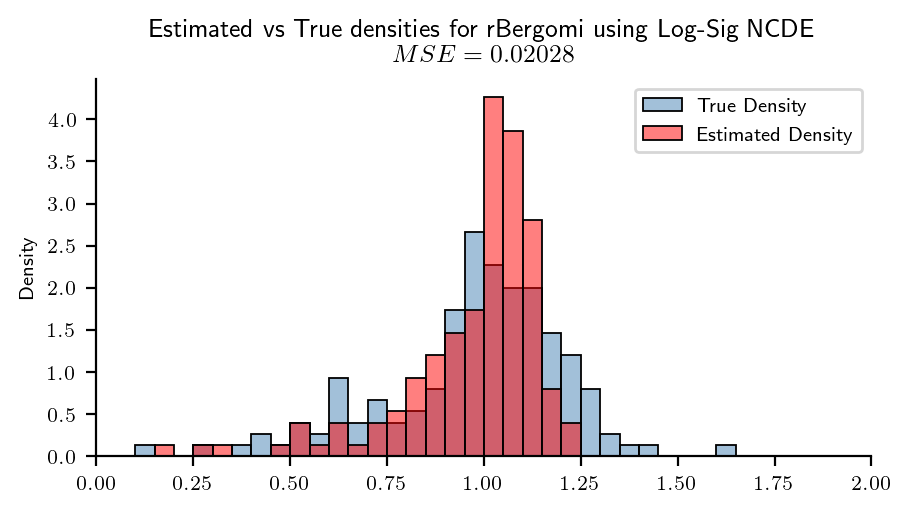

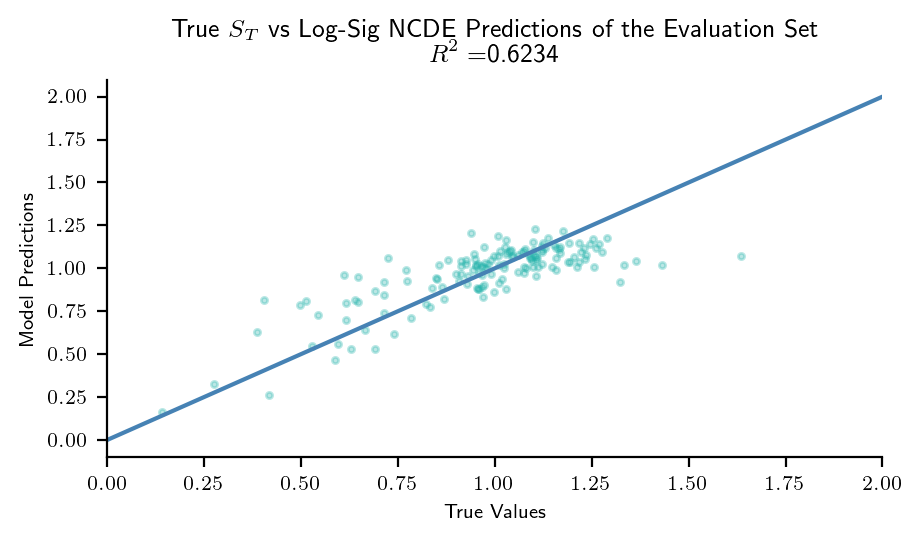

In [ ]:
if __name__ == '__main__':
    pred_y, NCDE_log_sig_model = main2(30)

In [ ]:
pickle.dump(NCDE_log_sig_model, open("/content/gdrive/My Drive/RPML_CW2/NCDE_log_sig_model.sav", 'wb'))
# NCDE_log_sig_model = pickle.load(open("/content/gdrive/My Drive/RPML_CW2/NCDE_log_sig_model.sav", 'rb'))

### Comparison Between Original NCDE Model and Log-Sig NCDE

The comparison between the two NCDE models is fascinating.

It looks as if the 2 NCDEs actually converge to the same model, despite having differing driving processes.

But while the trained models are similar, the log-sig NCDE trains and converges much faster than just the Brownian noise model - however computing the driving log-signature is computationally expensive.

We can clearly see there is some sort of limit of predictability that we are able to achieve with the current dataset. We also notice that there is a similar behaviour appearing in the NCDE as there is to the sig-KRR model. All 3 models we have created and trained have very similar behaviours in the sense that they cannot generalise to predict the right tail of the distribution.

We can actually start to observe just how close the 3 models are to one another by plotting the validation set outputs against eachother.

The plots highlight this similar behaviour in the right tail, however they do seem to generate slightly different left tails.

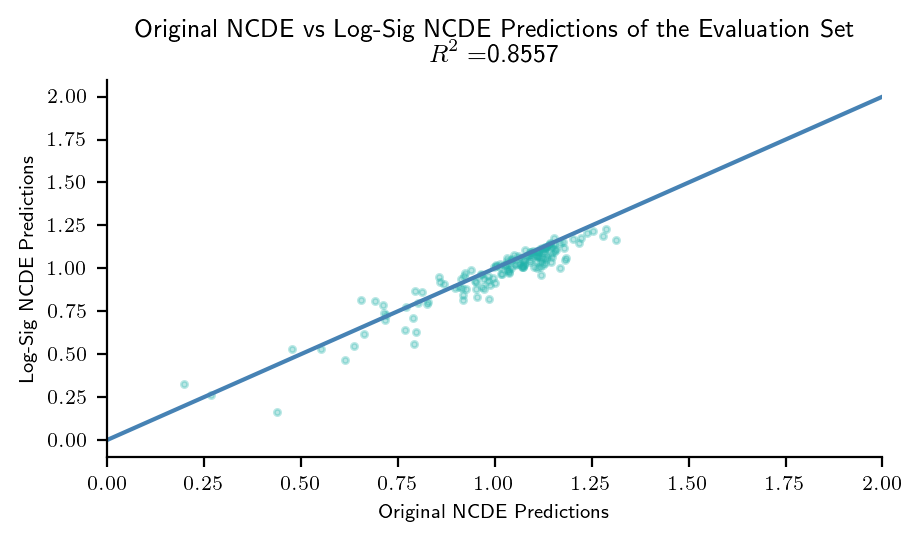

In [ ]:
# We now plot The predicted values against the true values and report the R^2 score
# Initialise figure
plt.rcParams['figure.dpi'] = 200
fig, ax1 = plt.subplots(1,1, figsize=(5,2.5))
# Produce a scatter plot with true values on x-axis and predictions on y-axis
plt.scatter(pred_y_orig.detach().cpu().numpy(), pred_y.detach().cpu().numpy(), s = 5, alpha = 0.3, color = 'lightseagreen')
ax1.set_title('Original NCDE vs Log-Sig NCDE Predictions of the Evaluation Set \n' + "$R^2 = $" + "{:.4f}".format(r2_score(pred_y_orig.detach().cpu().numpy(), pred_y.detach().cpu().numpy())), fontsize=9)
# Set plot parameters
plt.plot([0,2], [0,2], color = 'steelblue', linewidth=1.5)
ax1.tick_params(axis='y', labelsize=7)
ax1.yaxis.label.set_size(7)
ax1.xaxis.label.set_size(7)
right_side = ax1.spines["right"]
right_side.set_visible(False)
top_side = ax1.spines["top"]
top_side.set_visible(False)
plt.xlim([0,2])
plt.ylabel("Log-Sig NCDE Predictions")
plt.xlabel("Original NCDE Predictions")
ax1.tick_params(axis='x', labelsize=7)
ax1.tick_params(axis='y', labelsize=7)
plt.show()

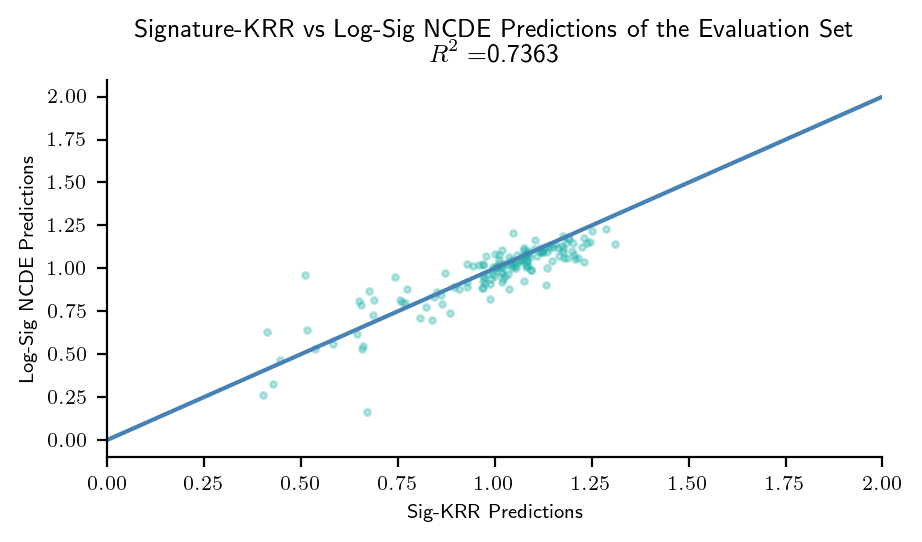

In [ ]:
# We now plot The predicted values against the true values and report the R^2 score
# Initialise figure
plt.rcParams['figure.dpi'] = 200
fig, ax1 = plt.subplots(1,1, figsize=(5,2.5))
# Produce a scatter plot with true values on x-axis and predictions on y-axis
plt.scatter(eval_predictions, pred_y.detach().cpu().numpy(), s = 5, alpha = 0.3, color = 'lightseagreen')
ax1.set_title('Signature-KRR vs Log-Sig NCDE Predictions of the Evaluation Set \n' + "$R^2 = $" + "{:.4f}".format(r2_score(eval_predictions, pred_y.detach().cpu().numpy())), fontsize=9)
# Set plot parameters
plt.plot([0,2], [0,2], color = 'steelblue', linewidth=1.5)
ax1.tick_params(axis='y', labelsize=7)
ax1.yaxis.label.set_size(7)
ax1.xaxis.label.set_size(7)
right_side = ax1.spines["right"]
right_side.set_visible(False)
top_side = ax1.spines["top"]
top_side.set_visible(False)
plt.xlim([0,2])
plt.ylabel("Log-Sig NCDE Predictions")
plt.xlabel("Sig-KRR Predictions")
ax1.tick_params(axis='x', labelsize=7)
ax1.tick_params(axis='y', labelsize=7)
plt.show()

## 6. Conclusion and Comparison Between The Sig-KRR and NCDE Models

The aim of this project was to see what we could learn about the relationship between the driving Brownian noise input of the rBergomi model and the terminal value of the price path generated by that noise.

Initially, when we first explore the model we can see that correlated 2-dimensional BM is the only source of randomness in the system and eventually 'flows' through many mappings, stochastic integrals and numerical schemes before evolving into the spot price at time $T$. It is then reasonable to assume that we should be able to learn this overall mapping from the BM to $S_T$ with a high level of accuracy. However, in practice we can see that the best model we created has around a 65% $R^2$ score on the validation set meaning there is quite a bit of missing information that the models are not able to capture.

The main driver for this overall mapping to not be deterministic could be due to ambiguity arising from numerical integration such as the hybrid scheme mentioned above. In this hybrid scheme, they approximate the kernel function by a power function near zero and by a step function elsewhere. 

We feel it would be interesting to do this same experiment on other probabilistic frameworks such as the Heston Model which in our hypothesis would yield a much better model prediction from the Brownian noise to the terminal spot price.

In our models, we noticed the same patterns appearing in each one, especially in the prediction of the right tail, this appeared to be accounting for most of the information the models couldn't capture. This particular phenomenon will require some further exploration.

Another interesting observation we made was that each model that we tried (Sig-KRR, Orig-NCDE, Log-Sig-NCDE) all converged to very similar models, we can see this from the above plots that in fact the Sig-KRR and Log-Sig-NCDE had a 73.6% $R^2$ on the predictions on the validation set despite being quite different by design. The two NCDE models we tried were even closer in their predictions, despite having very different inputs. We wonder if after several more epochs, they would actually converge even closer or become identical.

Overall, we have been able to tell a story about how the rBergomi model behaves, which is very valuable since the rBergomi model is especially complicated by nature with many variables and functions to keep track of. If we can further do more explanations numerically, we can start to delve even deeper into the model and perhaps find flaws in it or use these techniques to provide more intuition on how exactly it works. In terms of further experiments, it would be useful to test on other model frameworks (Heston, Black-Scholes, SABR etc) and perhaps even try to use these numerical ideas for option pricing.